In [63]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
import xgboost as xgb
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations, correlation_matrix
from src.models.learning_curve import learning_curve
from src.utils.directories import get_parent_directory
from src.models.encode_features import encode_tulabeldict
from src.models.corr_func import score_metrics, confidence_metrics

In [64]:
parent_dir = get_parent_directory()

In [65]:
global_pkl = os.path.join(parent_dir, "data/processed/Mashayek2022/input_microstructure.pkl")
global_df = pd.read_pickle(global_pkl)
global_df = global_df.rename(columns={'lat': 'latitude', 'log_N2_sort': 'log_N2'})

In [66]:
# Rename columns using the rename() method
waterhouse_df = global_df.rename(columns={'log_N2_sort': 'log_N2', 'log_kappa': 'LK', 'lat': 'latitude'})

In [67]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = (os.path.join(parent_dir, "data/processed/ml_ready/2706_time.pkl"))
arctic_df = pd.read_pickle(arctic_pkl)

Preprocessing data

In [68]:
arctic_df["Tu_label"] = Tu_label(arctic_df["Tu"])
arctic_df, labels = encode_tulabeldict(arctic_df)

In [69]:
# MLDJ generates better results than MLDI, also according to literature and visual inspectation
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]

# Convert 'inf' and '-inf' to 'NaN'
MLD_df = MLD_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with 'NaN' values
MLD_df = MLD_df.dropna()

# Round depth down to the nearest integer
MLD_df['rounded_depth'] = np.floor(MLD_df['depth']).astype(int)

# Filter the DataFrame to include only values that are multiples of ten
filtered_df = MLD_df[MLD_df['rounded_depth'] % 10 == 0]

# Filter the DataFrame to include only values that are multiples 

In [72]:
# Concatenate the DataFrames
waterhouse_df["depth"] = np.abs(waterhouse_df["depth"])
all_df = pd.concat([filtered_df, waterhouse_df], axis=0) 

In [73]:
pickle = all_df

In [16]:
len(pickle)

264265

In [79]:
xgb_regularised = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=700,
    learning_rate=0.01,  # Lower learning rate
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    random_state=42,
    subsample=0.5,
    gamma=0.1
)

# Train on limited features

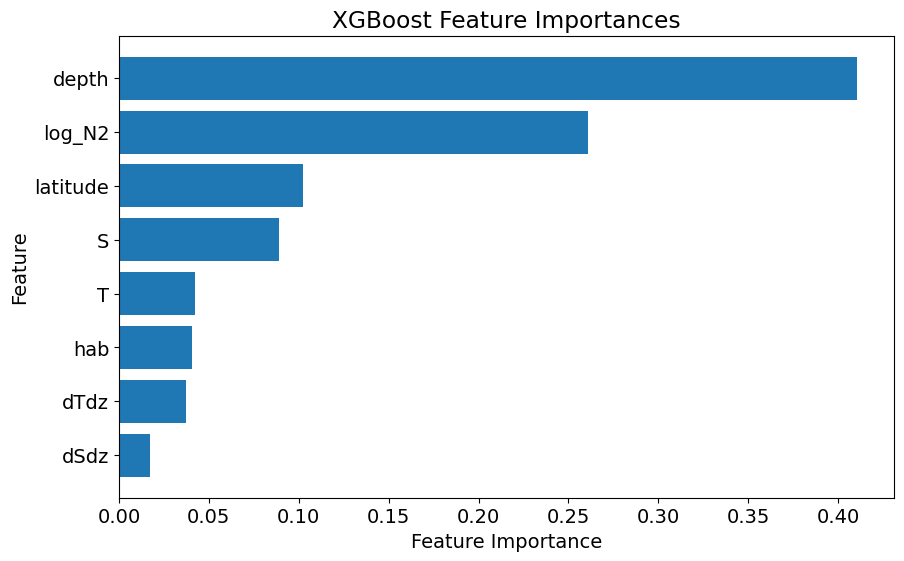

In [80]:
# random test train split, 0.970

# excluded 'sea_ice_concentration','latitude',
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'latitude']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised)

In [81]:
from pickle import dump, load

filename = os.path.join(parent_dir, "models/XGBoost_Global/xgboostGlobal.sav")
dump([xgb_regressor_all_SIC, X_train_SIC, X_test_all_SIC, y_train_SIC,y_test_all_SIC], open(filename, 'wb'))

In [19]:
r2_all_SIC

0.729060744807854

In [20]:
score_metrics(y_test_all_SIC, y_pred_all_SIC)

R2 Score: 0.7291
Mean Error (ME): 0.0076
Mean Absolute Error (MAE): 0.3141
Residual Standard Deviation: 0.4391


In [21]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Test generalisability on Barneo Cruise

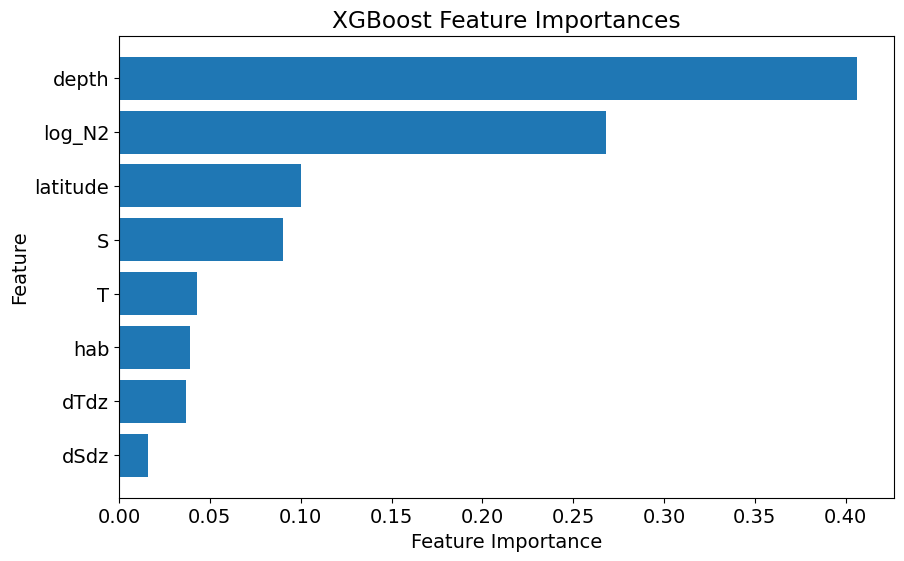

In [22]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test = "IPY Barneo 2008")

In [23]:
score_metrics(y_test_all_SIC, y_pred_all_SIC)

R2 Score: 0.1400
Mean Error (ME): 0.0651
Mean Absolute Error (MAE): 0.2073
Residual Standard Deviation: 0.3177


In [24]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

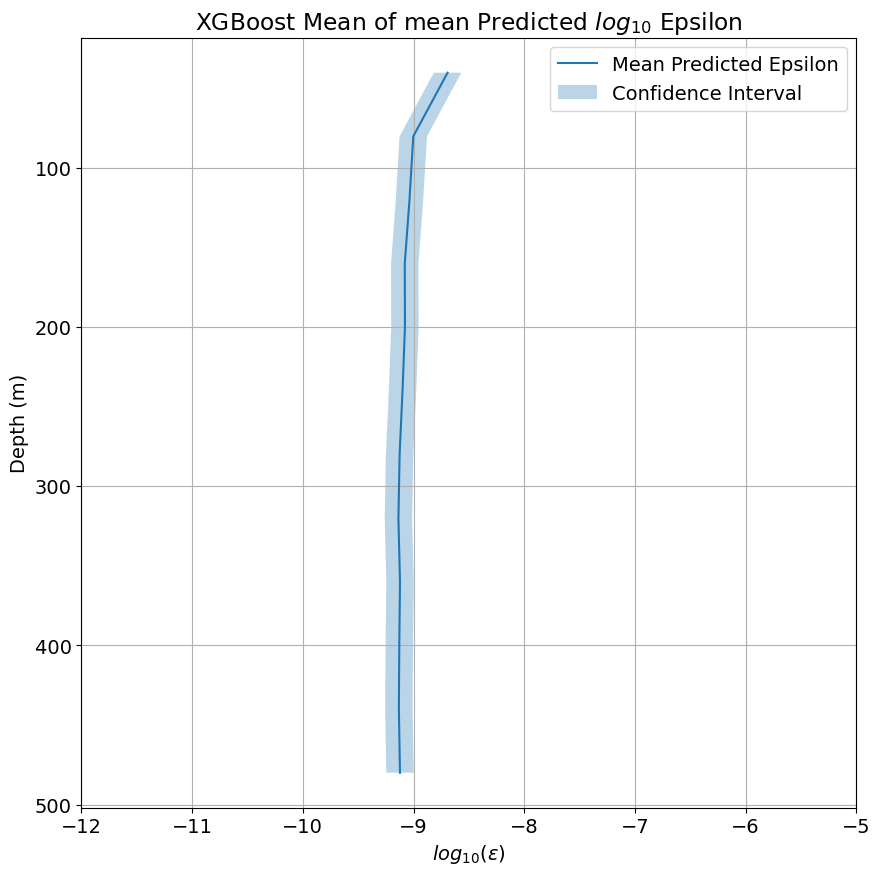

In [25]:
sorted_df = test_df.sort_values('depth')

# Sample every 10 meters
sampled_df = sorted_df[sorted_df['depth'] % 8 == 0]

# Group the data by depth and calculate the mean of epsilon predictions
mean_df = sampled_df.groupby('depth')['eps_pred'].mean().reset_index()

# Calculate the standard deviation
std_dev = mean_df['eps_pred'].std()

ci_lower = mean_df['eps_pred'] - std_dev  # Lower bound of the confidence interval
ci_upper = mean_df['eps_pred'] + std_dev  # Upper bound of the confidence interval

plt.plot(mean_df['eps_pred'], mean_df['depth'], label='Mean Predicted Epsilon')
plt.fill_betweenx(mean_df['depth'], ci_lower, ci_upper, alpha=0.3, label='Confidence Interval')
plt.xlabel('$log_{10}(\epsilon)$')
plt.ylabel('Depth (m)')
plt.title('XGBoost Mean of mean Predicted $log_{10}$ Epsilon')
plt.grid(True)
plt.legend()

# Set x-axis limits
plt.xlim(-12, -5)

plt.gca().invert_yaxis()  # Invert the y-axis

plt.show()


In [26]:
# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "data/Barneo2008_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

## Test on TEA-COSI

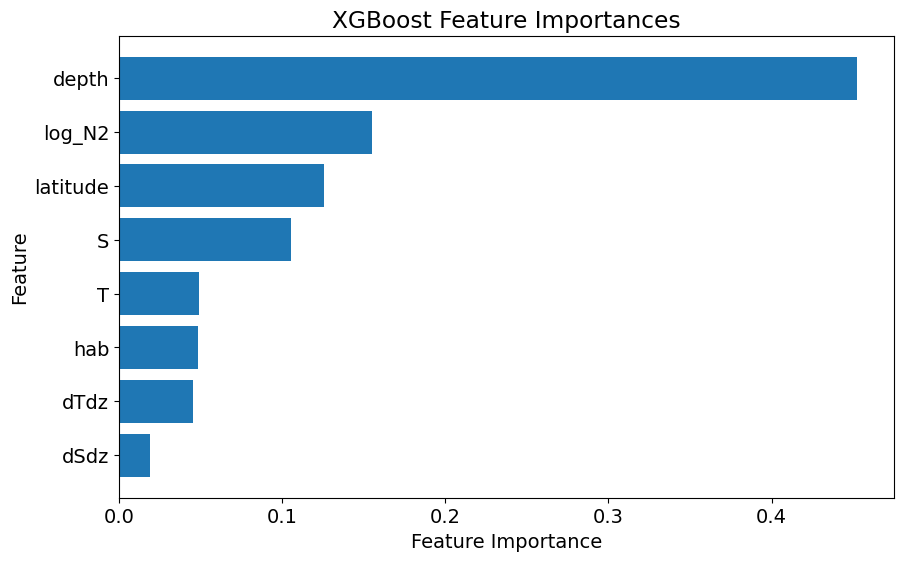

In [39]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test = "TEA_COSI")

In [40]:
score_metrics(y_test_all_SIC, y_pred_all_SIC)

R2 Score: -3.0502
Mean Error (ME): -0.6700
Mean Absolute Error (MAE): 1.0252
Residual Standard Deviation: 1.1684


In [41]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')
# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "data/TEA_COSI_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

## Test on cruise 14 (-55 lat)

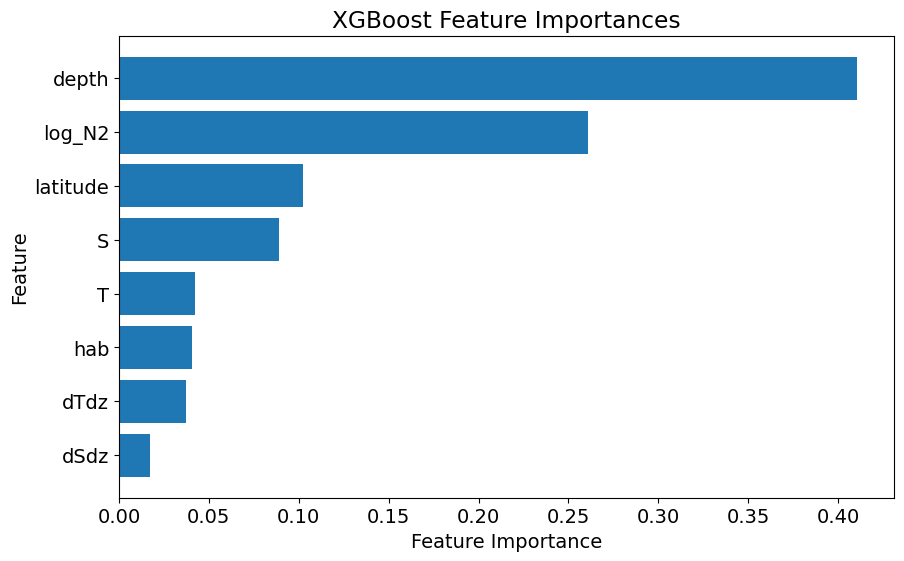

In [48]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test = 14)

In [49]:
score_metrics(y_test_all_SIC, y_pred_all_SIC)

R2 Score: 0.7291
Mean Error (ME): 0.0076
Mean Absolute Error (MAE): 0.3141
Residual Standard Deviation: 0.4391


In [50]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

In [51]:
# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost_global/14_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

## Mosaic

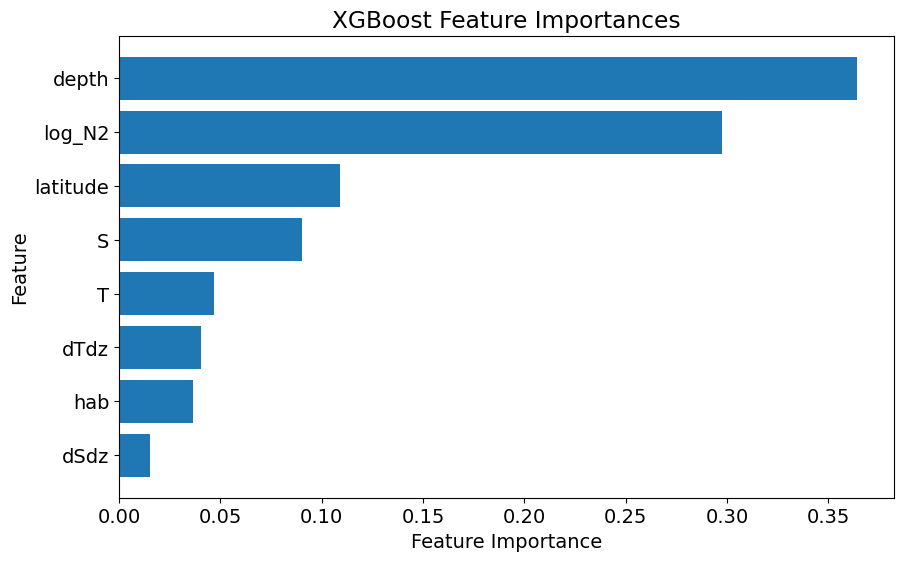

R2 Score: 0.3346
Mean Error (ME): 0.0914
Mean Absolute Error (MAE): 0.2772
Residual Standard Deviation: 0.4091


In [59]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test = "Mosaic")

score_metrics(y_test_all_SIC, y_pred_all_SIC)

In [60]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost_global/Mosaic_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

NICE-2015

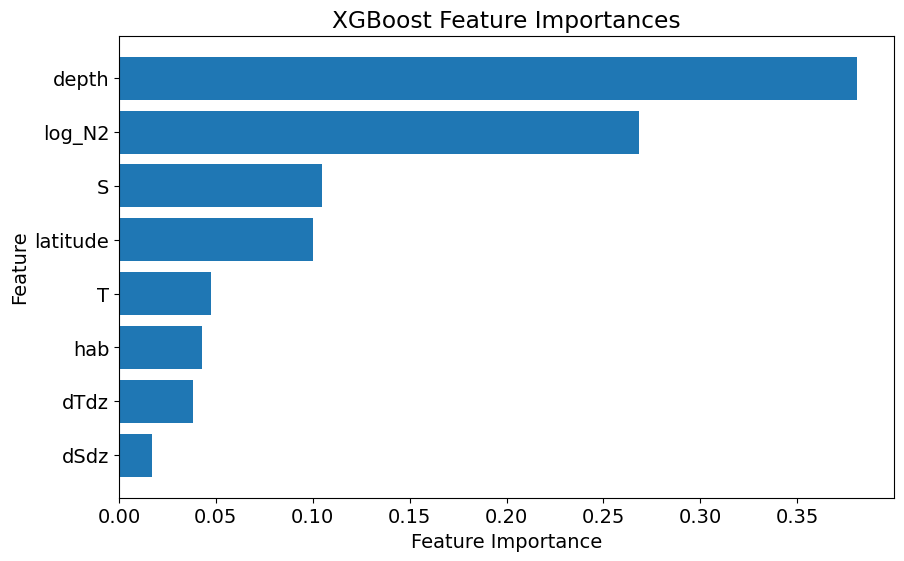

R2 Score: -1.1906
Mean Error (ME): -0.3901
Mean Absolute Error (MAE): 0.4896
Residual Standard Deviation: 0.4451


In [61]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test = "NICE-2015")

score_metrics(y_test_all_SIC, y_pred_all_SIC)

In [62]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost_global/NICE-2015_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

## Nansen Legacy 2009

In [75]:
pickle.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby', 'TEA_COSI',
       'ABSO', 'IPY Barneo 2007', 'IPY Barneo 2008', 'Nansen Legacy 2018',
       'Nansen Legacy 2019', 'ASCOS', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
       12, 13, 14], dtype=object)

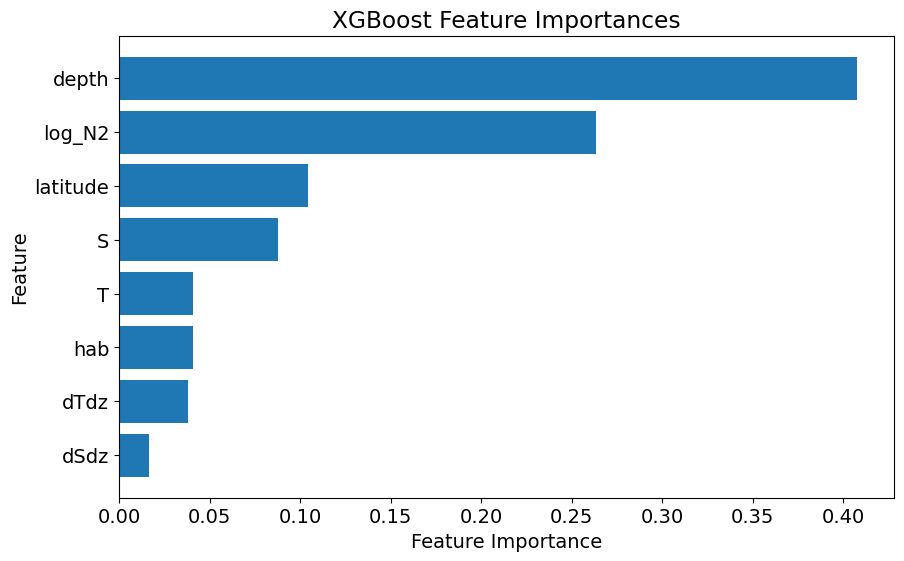

R2 Score: -0.9137
Mean Error (ME): 0.7052
Mean Absolute Error (MAE): 0.7543
Residual Standard Deviation: 0.4473


In [76]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test = "Nansen Legacy 2019")

score_metrics(y_test_all_SIC, y_pred_all_SIC)

In [77]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

In [78]:
# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost_global/Nansen2019_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)

## ArcticMix



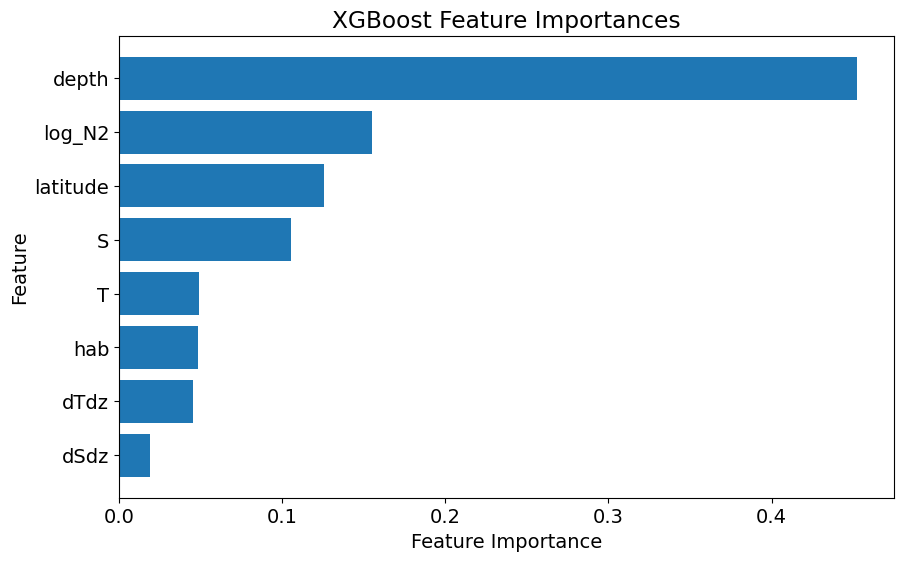

R2 Score: -3.0502
Mean Error (ME): -0.6700
Mean Absolute Error (MAE): 1.0252
Residual Standard Deviation: 1.1684


In [52]:
xgb_regressor_all_SIC, r2_all_SIC, y_test_all_SIC, y_pred_all_SIC, X_test_all_SIC, feature_importances_all_SIC, X_train_SIC, y_train_SIC  = XGBoost_regressor(pickle, xstringlist_all_SIC, ystringlist_all_SIC, cv=None, manual_regressor=xgb_regularised, cruise_test = "TEA_COSI")

score_metrics(y_test_all_SIC, y_pred_all_SIC)

In [53]:
# Reshape y_pred
y_pred_all_SIC = np.reshape(y_pred_all_SIC, (-1, 1))

X_test_df_SIC = pd.DataFrame(X_test_all_SIC, columns=xstringlist_all_SIC)
y_test_df_SIC = pd.DataFrame(y_test_all_SIC, columns=ystringlist_all_SIC)
y_pred_df_SIC = pd.DataFrame(y_pred_all_SIC, columns=['eps_pred'])

X_test_df_SIC['index'] = X_test_df_SIC.index
y_test_df_SIC['index'] = y_test_df_SIC.index
y_pred_df_SIC["index"] = y_pred_df_SIC.index

test_df = X_test_df_SIC.merge(y_test_df_SIC, on='index')
# Drop the index and create a new one
test_df['index'] = test_df.index
test_df = test_df.merge(y_pred_df_SIC, on='index')

In [54]:
# Specify the path and filename for the pickle file
pickle_path = os.path.join(parent_dir, "models/XGBoost_global/ArcticMix_testdf.pkl")
# Pickle the DataFrame
test_df.to_pickle(pickle_path)